<div>
<img src=https://www.institutedata.com/wp-content/uploads/2019/10/iod_h_tp_primary_c.svg width="300">
</div>

# Lab 5.3.1 
# *Support Vector Machines*

SVMs use linear algebra to find an (n-1)-dimensional boundary that separates classes within an n-dimensional space. In practical terms, this technique provides a conceptually simple way to predict class membership from a set of features. 

The standard (linear) SVM is immediately applicable to linear classification problems. Furthermore, by applying transformations to the feature space it is possible to tackle nonlinear classificaiton problems. These transforms are called *kernels*.

In [152]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

### 1. Load Data

Features are computed from a digitized image of a fine needle aspirate (FNA) of a breast mass. They describe characteristics of the cell nuclei present in the image. n the 3-dimensional space is that described in: [K. P. Bennett and O. L. Mangasarian: "Robust Linear Programming Discrimination of Two Linearly Inseparable Sets", Optimization Methods and Software 1, 1992, 23-34].

This database is also available through the UW CS ftp server: ftp ftp.cs.wisc.edu cd math-prog/cpo-dataset/machine-learn/WDBC/

Also can be found on UCI Machine Learning Repository: https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29

Attribute Information:

1) ID number 2) Diagnosis (M = malignant, B = benign) 3-32)

Ten real-valued features are computed for each cell nucleus:

a) radius (mean of distances from center to points on the perimeter) b) texture (standard deviation of gray-scale values) c) perimeter d) area e) smoothness (local variation in radius lengths) f) compactness (perimeter^2 / area - 1.0) g) concavity (severity of concave portions of the contour) h) concave points (number of concave portions of the contour) i) symmetry j) fractal dimension ("coastline approximation" - 1)

The mean, standard error and "worst" or largest (mean of the three largest values) of these features were computed for each image, resulting in 30 features. For instance, field 3 is Mean Radius, field 13 is Radius SE, field 23 is Worst Radius.

All feature values are recoded with four significant digits.

Missing attribute values: none

Class distribution: 357 benign, 212 malignant

In [115]:
breast_cancer_csv = 'breast-cancer-wisconsin-data.csv'

bc = pd.read_csv(breast_cancer_csv)

In [116]:
bc.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


### 2. EDA 

- Explore dataset. Clean data (if required)
- Find features to predict class

In [117]:
var_list = [name for name in bc.columns if name not in ['Unnamed: 32']]
bc = bc[var_list]

In [118]:
bc['diagnosis'] = bc['diagnosis'].apply(lambda x: x=='M')

In [119]:
d_corr = bc.corr()['diagnosis']
d_corr

id                         0.039769
diagnosis                  1.000000
radius_mean                0.730029
texture_mean               0.415185
perimeter_mean             0.742636
area_mean                  0.708984
smoothness_mean            0.358560
compactness_mean           0.596534
concavity_mean             0.696360
concave points_mean        0.776614
symmetry_mean              0.330499
fractal_dimension_mean    -0.012838
radius_se                  0.567134
texture_se                -0.008303
perimeter_se               0.556141
area_se                    0.548236
smoothness_se             -0.067016
compactness_se             0.292999
concavity_se               0.253730
concave points_se          0.408042
symmetry_se               -0.006522
fractal_dimension_se       0.077972
radius_worst               0.776454
texture_worst              0.456903
perimeter_worst            0.782914
area_worst                 0.733825
smoothness_worst           0.421465
compactness_worst          0

In [120]:
c_list = list(d_corr[d_corr.apply(lambda x: np.abs(x)>0.7)].index)
list(c_list)

['diagnosis',
 'radius_mean',
 'perimeter_mean',
 'area_mean',
 'concave points_mean',
 'radius_worst',
 'perimeter_worst',
 'area_worst',
 'concave points_worst']

### 3. Logistic Regression Model

#### 3.1 Use Logistic Regression

Use Logistic Regression and examine accuracy score, confusion matrix, classification report for that model.

- Define Target, Predictors
- Train-Test Split
- Evaluate Model

In [159]:
t_list = ['diagnosis']
p_list = [name for name in c_list if name not in t_list]

predictors = bc[p_list]
target = bc[t_list]

from sklearn.model_selection import train_test_split as split
p_train, p_test, t_train, t_test = split(predictors, target, test_size=0.2)

In [160]:
from sklearn.linear_model import LogisticRegression as lr
fitted_log = lr().fit(p_train, t_train.values)

fitted_log.score(p_test, t_test.values)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9473684210526315

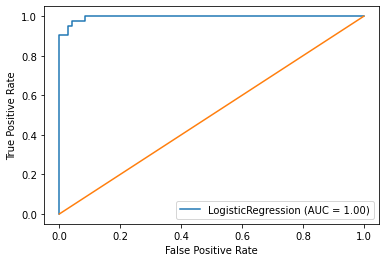

In [161]:
from sklearn.metrics import plot_roc_curve

plot_roc_curve(fitted_log, p_test, t_test)
plt.plot(np.array([0,1]), [0,1])

### 4. Support Vector Machine

#### 4.1 Use Support Vector Machine

Use Support Vector Machine and examine accuracy score, confusion matrix, classification report for that model.

- Define Target, Predictors
- Train-Test Split
- Evaluate Model

In [123]:
zero_train = t_train.isin([0]).values
one_train  = t_train.isin([1]).values.astype(bool)

zero_test  = t_test.isin([0]).values
one_test   = t_test.isin([1]).values.astype(bool)

In [124]:
def add_plus(arr):
    return np.append(arr, 1)

def add_minus(arr):
    return np.append(arr, -1)

In [125]:
zero_train_df = p_train[zero_train]
one_train_df  = p_train[one_train]

zero_test_df = p_test[zero_test]
one_test_df  = p_test[one_test]

X_one  = np.apply_along_axis(add_plus, axis=1, arr=zero_train_df.values)
X_zero = np.apply_along_axis(add_minus, axis=1, arr=one_train_df.values)

X = np.append(X_one, X_zero, axis=0)

y = t_train

In [126]:
from sklearn.pipeline import make_pipeline

from sklearn.svm import SVC as svc

fitted_svm = svc(gamma='auto').fit(X,y)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [127]:
X_one_test  = np.apply_along_axis(add_plus, axis=1, arr=zero_test_df.values)
X_zero_test = np.apply_along_axis(add_minus, axis=1, arr=one_test_df.values)

X_test = np.append(X_one_test, X_zero_test, axis=0)

y_test = t_test

In [128]:
fitted_svm.score(X_test,y_test)

0.6228070175438597

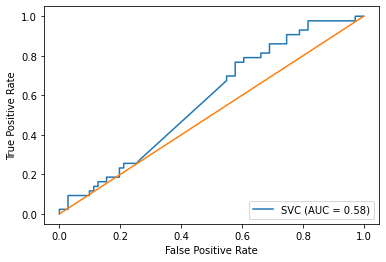

In [157]:
from sklearn.metrics import plot_roc_curve

plot_roc_curve(fitted_svm, X_test, y_test)
plt.plot(np.array([0,1]), [0,1])

### 5. Naive Bayes
#### 5.1 Use Naive Bayes

Use Naive Bayes and examine accuracy score, confusion matrix, classification report for that model.

- Define Target, Predictors
- Train-Test Split
- Evaluate Model

In [88]:
from sklearn.naive_bayes import GaussianNB as gau

fitted_bayes = gau().fit(p_train, t_train)

fitted_bayes.score(p_test, t_test)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.9035087719298246

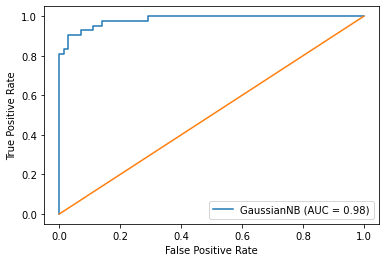

In [162]:
plot_roc_curve(fitted_bayes, p_test, t_test)
plt.plot(np.array([0,1]), [0,1])

### 6 Gridsearch optimal parameters for all three models.

Is there any difference between accuracy score of Logistic Regression and SVM? Use grid serach to find optimal parameter for both these models.

> Hyper-parameters are parameters that are not directly learnt within estimators. In scikit-learn they are passed as arguments to the constructor of the estimator classes. Typical examples include C, kernel and gamma for Support Vector Classifier, alpha for Lasso, etc.

> It is possible and recommended to search the hyper-parameter space for the best cross validation score.

> https://scikit-learn.org/stable/modules/grid_search.html#grid-search

**Note:** It'll take time to execute this. After running the cell, wait for result.

In [89]:
from sklearn.model_selection import GridSearchCV as grid

#### 6.1 Find Best Estimator For Logistic Regression 

Find out how these parameters effect model. Find out the best estimator, score.

In [163]:
lr_params = {
    'penalty': ['l1','l2'],
    'C': [1, 10, 100]
}

grid_log = grid(estimator=lr(), param_grid=lr_params)

fitted_g_log = grid_log.fit(p_train, t_train)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.p

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or s

In [164]:
fitted_g_log.score(p_test, t_test)

0.9473684210526315

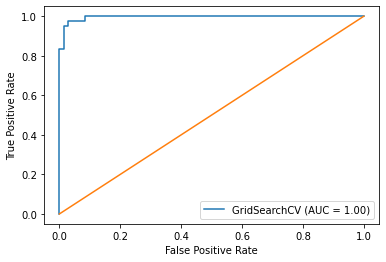

In [166]:
plot_roc_curve(fitted_g_log, p_test, t_test)
plt.plot(np.array([0,1]), [0,1])

#### 6.2 Find Best Estimator For SVM

Find out how these parameters effect model. Find out the best estimator, score.

In [ ]:
svc_params = {
    'C': [1, 10, 100],
    'gamma': [0.001, 0.0001],
    'kernel': ['linear','rbf']
}

grid_svc = grid(estimator=svc(), param_grid=svc_params)

fitted_g_svc = grid_svc.fit(X, y)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

In [66]:
fitted_g_svc.score(X_test, y_test)

NameError: name 'fitted_g_svc' is not defined

#### 6.3 Plot the ROC curve for the SVM, Logistic Regressions and Naive Bayes on the same plot

Find out which model performs better.

In [167]:
#plt.figure(figsize=[8,8])
#plt.xlim([-0.05, 1.0])
#plt.ylim([-0.05, 1.05])
#plt.xlabel('False Positive Rate', fontsize=18)
#plt.ylabel('True Positive Rate', fontsize=18)
#plt.title('Receiver Operating Characteristic: M', fontsize=18)
#plt.legend(loc="lower right")
#plt.show()

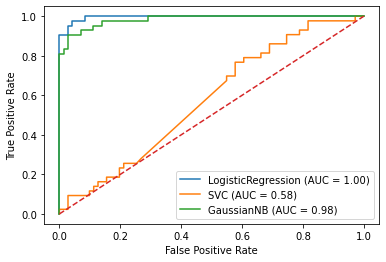

In [185]:
PLOT = plot_roc_curve(fitted_log, p_test, t_test)
plot_roc_curve(fitted_svm, X_test, y_test, ax=PLOT.ax_)
plot_roc_curve(fitted_bayes, p_test, t_test, ax=PLOT.ax_)
plt.plot(np.array([0,1]), [0,1], linestyle='--')

plt.show()

### 7. [BONUS] Learning Curve

A learning curve shows the validation and training score of an estimator for varying numbers of training samples. It is a tool to find out how much we benefit from adding more training data and whether the estimator suffers more from a variance error or a bias error. If both the validation score and the training score converge to a value that is too low with increasing size of the training set, we will not benefit much from more training data.

Plot "learning curves" for the best models of each. This is a great way see how training/testing size affects the scores. Look at the documentation for how to use this function in sklearn.

http://scikit-learn.org/stable/modules/learning_curve.html#learning-curves

In [0]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr-auto-examples-model-selection-plot-learning-curve-py

**References**

[Breast Cancer Wisconsin (Diagnostic) Data Set](https://www.kaggle.com/uciml/breast-cancer-wisconsin-data/downloads/breast-cancer-wisconsin-data.zip/2)

[Validation curves: plotting scores to evaluate models](https://scikit-learn.org/stable/modules/learning_curve.html#learning-curves)

[In-Depth: Support Vector Machines](https://jakevdp.github.io/PythonDataScienceHandbook/05.07-support-vector-machines.html)

[Understanding Support Vector Machine algorithm from examples (along with code)](https://www.analyticsvidhya.com/blog/2017/09/understaing-support-vector-machine-example-code/)

[Tuning the hyper-parameters of an estimator](https://scikit-learn.org/stable/modules/grid_search.html#grid-search)



---



---



> > > > > > > > > © 2021 Institute of Data


---



---



